#  Data Quality Cuts
The purpose of this notebook is to follow Matt's work https://zzz.physics.umn.edu/!cdms/cdms/k100/run_summary/run_76/data_quality_cuts (login required).

In [30]:
#Imports
import math
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import matplotlib.pyplot as plt #Basic plotting library
import lmfit as lf              #Fitting
from matplotlib import cm
from matplotlib import colors
sys.path.append('../')
import R76Tools as R76
gaus_mod = lf.Model(R76.gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=300)
gaus_params.add('sigma',min=0,value=3,max=200)
gaus_params.add('mu',min=100,max=300,value=150)

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"

In [3]:
datapath=frittspath
ser=["07220827_1153","07220916_2059","07220917_1039","07220917_2125"]
lab=["0V","-4V","-21V","-65V","-84V","-84V"]
_,z = R76.makechain_list(ser,path=datapath,filters=[R76.fittingfilters,"PTOFamps0"],aliases=R76.calibrationaliases)

## Cuts and aliases

In [4]:
# A lot of this is similar to tutorial replication.
crand=[]; cgoodwalk=[]; cbs=[]
for x in z:
    crand.append(x['EventCategory']==1)
    cgoodwalk.append((x['PCWKr20'] > 0.25e-3)    #The result of ConstFreqRTFTWalk is probably good,
                     & (x['PCWKr20']<0.5e-3)     #based on rise times.
                     & (x['PDWKr20']>0.25e-3)    #This is a quality cut.
                     & (x['PDWKr20']<0.5e-3)
                     & (x['PEWKr20']>0.25e-3)
                     & (x['PEWKr20']<0.5e-3))
    x['PTwid']=(x['PTWKf40']-x['PTWKr40'])*1e6
    x['xdel']=1e6*(x['PEWKr20']-0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel']=1e6*(0.866*(x['PDWKr20']-x['PCWKr20']))+9
    x['phidel']=[180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['afdel']=1e6*(x['PFWKr20']-x['PAWKr20'])
    x['pt_keV']=7.738820e+07*x['PTOFamps']+1.653756e+13*x['PTOFamps']**2
    x['pt0_keV']=7.738820e+07*x['PTOFamps0']+1.653756e+13*x['PTOFamps0']**2
    x['PSUMbs']=x['PAbs']+x['PBbs']+x['PCbs']+x['PDbs']+x['PEbs']+x['PFbs']
    x['BSel']=x['PSUMbs']-18400
    x['pt_keV_bscorr']=x['pt_keV']/(1.-0.0461538*x['BSel']/165)
    x['pt0_keV_bscorr']=x['pt0_keV']/(1.-0.0461538*x['BSel']/165)
    cbs.append(x['BSel']<1100)
    x['pt_keVee']=14.0821*x['pt_keV_bscorr']/(333.899-x['pt_keV_bscorr'])
    x['pt0_keVee']=14.0821*x['pt0_keV_bscorr']/(333.899-x['pt0_keV_bscorr'])
    x['PTdbs']=(x['PAbspost']-x['PAbs']) + (x['PBbspost']-x['PBbs']) + (x['PCbspost']-x['PCbs']) + (x['PDbspost']-x['PDbs'])\
    + (x['PEbspost']-x['PEbs']) + (x['PFbspost']-x['PFbs'])
    x['PTINTall_PTdbscorr']=x['PTINTall']-(x['PTdbs']<0)*0.5*(x['PTdbs']*4096./x['PFnorm'])

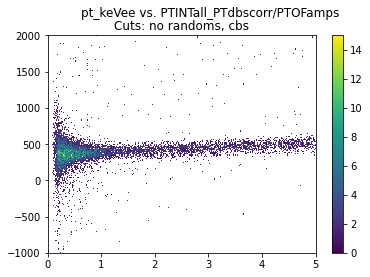

In [5]:
fig, ax = plt.subplots()
binsx=np.linspace(0,5,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z[1]['pt_keVee'][~crand[1]&cbs[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,5)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.show()

In [6]:
# More Cuts
cofintl=[]; cofintt=[]
for x in z:
    cofintl.append((x['PTINTall_PTdbscorr']/x['PTOFamps']>50)&(x['PTINTall_PTdbscorr']/x['PTOFamps']<750))
    cofintt.append((x['PTINTall_PTdbscorr']/x['PTOFamps']>250)&(x['PTINTall_PTdbscorr']/x['PTOFamps']<550))

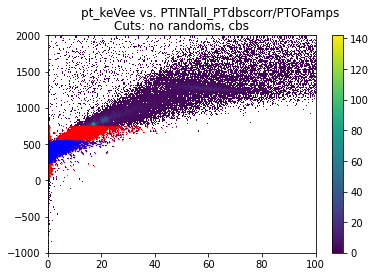

In [7]:
fig, ax = plt.subplots()
binsx=np.linspace(0,100,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z[1]['pt_keVee'][~crand[1]&cbs[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,100)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.scatter(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintl[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]&cofintl[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]&cofintl[1]],
           cmap=cmap,vmin=1e-10,color='r',s=0.1)
plt.scatter(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintt[1]],z[1]['PTINTall_PTdbscorr'][~crand[1]&cbs[1]&cofintt[1]]/z[1]['PTOFamps'][~crand[1]&cbs[1]&cofintt[1]],
           cmap=cmap,vmin=1e-10,color='blue',s=0.1)
plt.show()

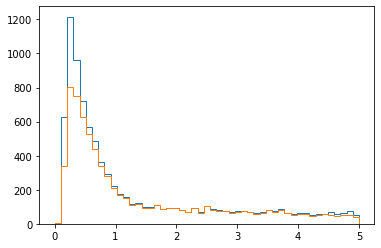

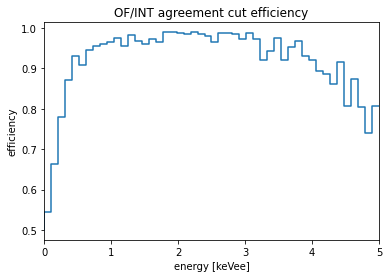

In [8]:
a=plt.hist(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintl[1]],bins=np.linspace(0,5,50),histtype='step')
b=plt.hist(z[1]['pt_keVee'][~crand[1]&cbs[1]&cofintt[1]],bins=np.linspace(0,5,50),histtype='step')
plt.show() # Ignore this graph
c=plt.step(np.linspace(0,5,49),b[0]/a[0])
plt.xlim(0,5)
plt.title('OF/INT agreement cut efficiency')
plt.xlabel('energy [keVee]')
plt.ylabel('efficiency')
plt.show()

In [9]:
cofintvl=[]
for x in z:
    cofintvl.append((x['PTINTall_PTdbscorr']/x['PTOFamps']>-700)&(x['PTINTall_PTdbscorr']/x['PTOFamps']<1500))
ngood=len(z[1][~crand[1]&cbs[1]&cofintvl[1]&(z[1]['pt_keVee']>0.035)&(x['pt_keVee']<0.5)])
npass=len(z[1][~crand[1]&cbs[1]&cofintt[1]&(z[1]['pt_keVee']>0.035)&(x['pt_keVee']<0.5)])
npass/ngood

0.21177906621910284

# Improved Curved Cut

In [11]:
ser=["07220916_2059","07220916_2200","07220917_1039","07220917_1225","07220917_2125","07220917_2155"]; calser=[]
lab=["0V","-4V","-21V","-65V","-84V","-84V"]
for i,s in enumerate(ser):
    if i%2==0:
        calser.append(ser[i])
_,z,_ = R76.makechain_list(calser,path=datapath,filters=[R76.fittingfilters,"PTOFamps0"],aliases=R76.calibrationaliases,trees=["e","z","z4"])
z_all = pd.DataFrame();
for i,x in enumerate(z):
    z_all = pd.concat([z_all,x])

In [12]:
crand=[]; cbs=[]
crand.append(z_all['EventCategory']==1)
z_all['pt_keV']=7.738820e+07*z_all['PTOFamps']+1.653756e+13*z_all['PTOFamps']**2
z_all['pt0_keV']=7.738820e+07*z_all['PTOFamps0']+1.653756e+13*z_all['PTOFamps0']**2
z_all['PSUMbs']=z_all['PAbs']+z_all['PBbs']+z_all['PCbs']+z_all['PDbs']+z_all['PEbs']+z_all['PFbs']
z_all['BSel']=z_all['PSUMbs']-18400
z_all['pt_keV_bscorr']=z_all['pt_keV']/(1.-0.0461538*z_all['BSel']/165)
z_all['pt0_keV_bscorr']=z_all['pt0_keV']/(1.-0.0461538*z_all['BSel']/165)
cbs.append(z_all['BSel']<1100)
z_all['pt_keVee']=14.0821*z_all['pt_keV_bscorr']/(333.899-z_all['pt_keV_bscorr'])
z_all['pt0_keVee']=14.0821*z_all['pt0_keV_bscorr']/(333.899-z_all['pt0_keV_bscorr'])
z_all['PTdbs']=(z_all['PAbspost']-z_all['PAbs']) + (z_all['PBbspost']-z_all['PBbs']) + (z_all['PCbspost']-z_all['PCbs'])\
    + (z_all['PDbspost']-z_all['PDbs']) + (z_all['PEbspost']-z_all['PEbs']) + (z_all['PFbspost']-z_all['PFbs'])
z_all['PTINTall_PTdbscorr']=z_all['PTINTall']-(z_all['PTdbs']<0)*0.5*(z_all['PTdbs']*4096./z_all['PFnorm'])

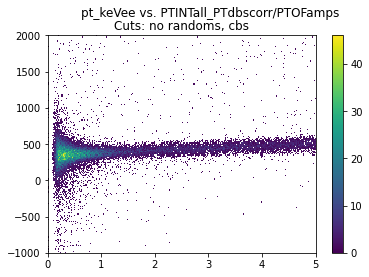

In [13]:
fig, ax = plt.subplots()
binsx=np.linspace(0,5,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z_all['pt_keVee'][~crand[0]&cbs[0]],z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]]/z_all['PTOFamps'][~crand[0]&cbs[0]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,5)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.show()

In [78]:
edges=[0.1,0.2,0.3,0.4,0.6,0.8,1,1.5,2,3,4,5]
slices=[]; midpoints=[]
for i in range(len(edges)-1):
    slices.append((z_all['pt_keVee']>edges[i])&(z_all['pt_keVee']<edges[i+1]))
    midpoints.append((edges[i]+edges[i+1])/2)

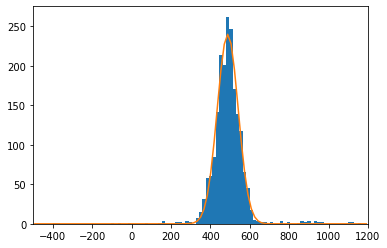

In [75]:
slicenum=10
h4n=plt.hist(z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]&slices[slicenum]]/z_all['PTOFamps'][~crand[0]&cbs[0]&slices[slicenum]],bins=np.linspace(-500,1200,100))
plt.xlim(-500,1200)
if slicenum>3:
    a=380
else:
    a=270
gaus_params.add('mu',value=a)
bins = (h4n[1][:-1]+h4n[1][1:])/2
fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
plt.plot(bins,fit_NTL.best_fit)
plt.show()
fit_NTL

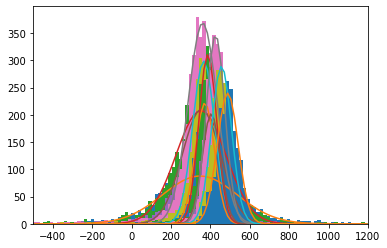

In [77]:
mu_values=[]; A_values=[]; sigma_values=[]
for slicenum in range(len(slices)):
    h4n=plt.hist(z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]&slices[slicenum]]/z_all['PTOFamps'][~crand[0]&cbs[0]&slices[slicenum]],bins=np.linspace(-500,1200,100))
    plt.xlim(-500,1200)
    if slicenum>3:
        a=380
    else:
        a=270
    gaus_params.add('mu',value=a)
    bins = (h4n[1][:-1]+h4n[1][1:])/2
    fit_NTL = gaus_mod.fit(h4n[0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
    plt.plot(bins,fit_NTL.best_fit)
    mu_values.append(fit_NTL.params['mu'].value)
    A_values.append(fit_NTL.params['A'].value)
    sigma_values.append(fit_NTL.params['sigma'].value)
plt.show()
# Ignore the runoff plot!

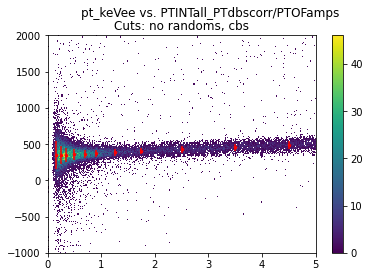

In [87]:
fig, ax = plt.subplots()
binsx=np.linspace(0,5,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z_all['pt_keVee'][~crand[0]&cbs[0]],z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]]/z_all['PTOFamps'][~crand[0]&cbs[0]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,5)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.scatter(midpoints,mu_values,color='r',s=10,marker='*')
plt.errorbar(midpoints,mu_values,yerr=sigma_values,color='r',linestyle='none')
plt.show()

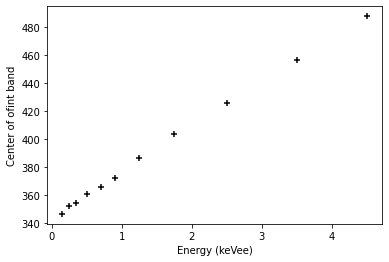

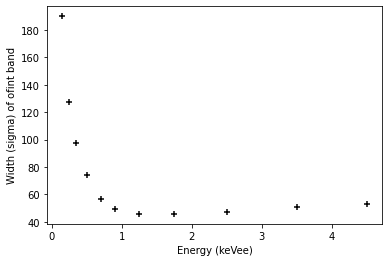

In [97]:
plt.scatter(midpoints,mu_values,marker='+',color='black')
plt.xlabel('Energy (keVee)')
plt.ylabel('Center of ofint band')
plt.show()
plt.scatter(midpoints,sigma_values,marker='+',color='black')
plt.xlabel('Energy (keVee)')
plt.ylabel('Width (sigma) of ofint band')
plt.show()

In [108]:
def exp(x):
    return 2.71828**x
cofintc=[]
df1=z_all['pt_keVee']<0.3661
df1=df1.astype('int')
df2=(z_all['pt_keVee']>=0.3661)&(z_all['pt_keVee']<0.9452)
df2=df2.astype('int')
df3=z_all['pt_keVee']>=0.9452
df3=df3.astype(int)
z_all['ofint_sig']=df1*(302.84*exp(-3.108*z_all['pt_keVee']))+df2*(42.044*z_all['pt_keVee']**2-143.59*z_all['pt_keVee']+144)+df3*(0.5817*z_all['pt_keVee']**2-0.833*z_all['pt_keVee']+46.109)
z_all['ofint_ctr']=343.7+34.18*z_all['pt_keVee']-0.5833*z_all['pt_keVee']**2
cofintc.append((z_all['PTINTall_PTdbscorr']/z_all['PTOFamps']>z_all['ofint_ctr']-1.96*z_all['ofint_sig'])\
               &(z_all['PTINTall_PTdbscorr']/z_all['PTOFamps']<z_all['ofint_ctr']+1.96*z_all['ofint_sig']))

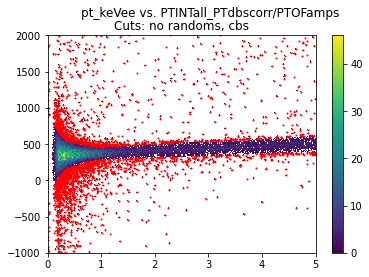

In [111]:
fig, ax = plt.subplots()
binsx=np.linspace(0,5,300)
binsy=np.linspace(-1000,2000,200)
# Setup for white bg
cmap = cm.viridis.copy()
cmap.set_under('w')
h=ax.hist2d(z_all['pt_keVee'][~crand[0]&cbs[0]],z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]]/z_all['PTOFamps'][~crand[0]&cbs[0]],
           bins=[binsx,binsy],cmap=cmap,vmin=1e-10)
fig.colorbar(h[3], ax=ax)
plt.xlim(0,5)
plt.ylim(-1000,2000)
plt.suptitle('pt_keVee vs. PTINTall_PTdbscorr/PTOFamps')
plt.title("Cuts: no randoms, cbs")
plt.scatter(z_all['pt_keVee'][~crand[0]&cbs[0]&~cofintc[0]],z_all['PTINTall_PTdbscorr'][~crand[0]&cbs[0]&~cofintc[0]]/z_all['PTOFamps'][~crand[0]&cbs[0]&~cofintc[0]]\
           ,s=1,color='r')
plt.show()

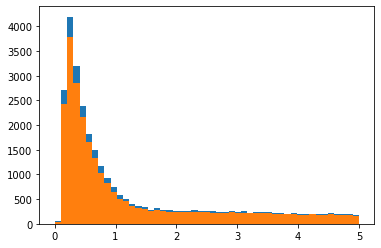

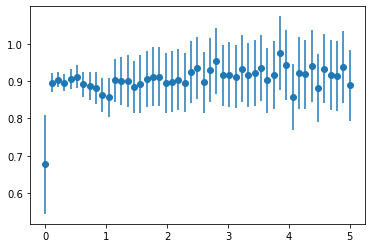

In [129]:
cofintvl=[]
cofintvl.append((z_all['PTINTall_PTdbscorr']/z_all['PTOFamps']>-700)&(z_all['PTINTall_PTdbscorr']/z_all['PTOFamps']<1500))
h1=plt.hist(z_all['pt_keVee'][~crand[0]&cbs[0]&cofintvl[0]],bins=np.linspace(0,5,50))
h2=plt.hist(z_all['pt_keVee'][~crand[0]&cbs[0]&cofintvl[0]&cofintc[0]],bins=np.linspace(0,5,50))
plt.show() # Can safely ignore this one
plt.scatter(np.linspace(0,5,49),h2[0]/h1[0])
plt.errorbar(np.linspace(0,5,49),h2[0]/h1[0],yerr=h2[0]/h1[0]*np.sqrt(1/h1[0]+1/h2[0]),linestyle='none')
plt.show()